# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [310]:
import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dropout,
    Dense,
    AveragePooling1D,
    Concatenate,
    Conv1D,
    Flatten,
)
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [311]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


# Load Data

In [312]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [313]:
# 从文件中提取数据
file_path = "../shear2/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset3 = pickle.load(file)

print(dataset3)  # 输出：[1, 2, 3, 4, 5]
dataset3[0].x.shape

MyGraphDataset(n_graphs=60)


(8, 4000)

In [314]:
# 从文件中提取数据
file_path = "../shear/vasp_cal/dos_energy_data.pkl"
with open(file_path, "rb") as file:
    dataset2 = pickle.load(file)

print(dataset2)  # 输出：[1, 2, 3, 4, 5]
dataset2[0].x.shape

MyGraphDataset(n_graphs=120)


(8, 4000)

In [315]:
# 从文件中提取数据
data_path = "./vasp_cal/"  # 当前文件执行的文件夹，包括输出和输入文件夹
dos_energy_data_file = data_path + "dos_energy_data.pkl"
with open(dos_energy_data_file, "rb") as file:
    dataset1 = pickle.load(file)

print(dataset1)  # 输出：[1, 2, 3, 4, 5]
dataset1[0].x.shape

MyGraphDataset(n_graphs=594)


(8, 4000)

In [316]:
graph_data = []
for i in range(len(dataset1)):
    g = dataset1[i]
    graph_data.append(g)

for i in range(len(dataset2)):
    g = dataset2[i]
    graph_data.append(g)

for i in range(len(dataset3)):
    g = dataset2[i]
    graph_data.append(g)

dataset = MyGraphDataset(graph_data)
dataset

MyGraphDataset(n_graphs=774)

# Build GCN model

In [317]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(4000, 4, 1)

In [318]:
learning_rate = 1e-4  # Learning rate
epochs = 50  # Number of training epochs
batch_size = 16  # Batch size

In [319]:
def dos_featurizer(length, channel):
    input_dos = Input(shape=(length, channel))  # 400, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)  # 窗口 步长
    x2 = AveragePooling1D(pool_size=64, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=128, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])  # 沿着最后一个轴拼接
    x = Conv1D(256, 64, activation="relu", padding="same", strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 32, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(64, 16, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(32, 8, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(16, 8, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [320]:
def dos_featurizer2(length, channel):
    input_dos = Input(shape=(length, channel))  # 800, 5
    x1 = AveragePooling1D(pool_size=4, strides=4, padding="same")(input_dos)
    x2 = AveragePooling1D(pool_size=25, strides=4, padding="same")(input_dos)
    x3 = AveragePooling1D(pool_size=200, strides=4, padding="same")(input_dos)
    x = Concatenate(axis=-1)([x1, x2, x3])
    x = Conv1D(50, 20, activation="relu", padding="same", strides=4)(x)
    x = BatchNormalization()(x)
    x = Conv1D(75, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(100, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(125, 3, activation="relu", padding="same", strides=2)(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding="same")(x)
    x = Conv1D(150, 3, activation="relu", padding="same", strides=2)(x)
    x = tf.squeeze(x)
    shared_model = Model(input_dos, x)
    return shared_model

In [321]:
channels = 5
length = int(F / channels)  # 400
shared_conv = dos_featurizer(length, channels)

In [322]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)  # dos feature

        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [323]:
model = Net()
model.layers

In [324]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [325]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [326]:
istrain = True
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Loss: 0.5379257202148438
Loss: 0.10792725533246994
Loss: 0.08806132525205612
Loss: 0.08297276496887207
Loss: 0.0765729621052742
Loss: 0.0419972687959671
Loss: 0.029990745708346367
Loss: 0.023090513423085213
Loss: 0.01866839826107025
Loss: 0.030200378969311714
Loss: 0.047341443598270416
Loss: 0.031616244465112686
Loss: 0.03613930568099022
Loss: 0.02959458902478218
Loss: 0.021784715354442596
Loss: 0.018914587795734406
Loss: 0.01659972220659256
Loss: 0.014729645103216171
Loss: 0.014162025414407253
Loss: 0.014385980553925037
Loss: 0.014110822230577469
Loss: 0.013541016727685928
Loss: 0.01306553278118372
Loss: 0.012998715043067932
Loss: 0.012827325612306595
Loss: 0.013407430611550808
Loss: 0.012714138254523277
Loss: 0.011816883459687233
Loss: 0.011625302024185658
Loss: 0.011642160825431347
Loss: 0.011891073547303677
Loss: 0.011404979042708874
Loss: 0.011117735877633095
Loss: 0.010708450339734554
Loss: 0.010812872089445591
Loss: 0.010396824218332767
Loss: 0.009992395527660847
Loss: 0.0099341

In [327]:
# Train/valid/test split
data = np.array(graph_data)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [328]:
type(data_tr)

numpy.ndarray

In [329]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)

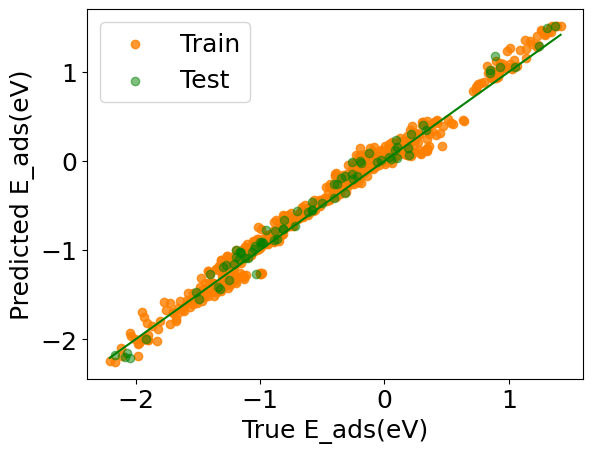

In [330]:
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

In [331]:
import math
from sklearn.metrics import mean_squared_error

# 假设 y_pred 和 y_true 是两个长度相同的数组，分别代表预测值和真实值
# 计算均方根误差
rmse = math.sqrt(mean_squared_error(data0[:, 1], data0[:, 0]))
print("RMSE:", rmse)

RMSE: 0.10954811113064063


In [332]:
rmse = math.sqrt(mean_squared_error(data1[:, 1], data1[:, 0]))
print("RMSE:", rmse)

RMSE: 0.11260886082126847


In [333]:
class FeatureExtraction(Model):
    def __init__(self):
        super().__init__()
        self.share = shared_conv
        self.conv1 = ECCConv(128, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        # self.conv3 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = tf.reshape(x, (-1, length, channels))
        x = shared_conv(x)

        x = self.conv1([x, a, e])
        feature1 = x  # 保存第一层卷积的特征
        x = self.conv2([x, a, e])
        feature2 = x  # 保存第二层卷积的特征
        output = self.global_pool([x, i])
        output = tf.keras.layers.Flatten()(output)
        output = self.dense0(output)
        feature3 = output
        output = self.dense(output)

        return output, feature1, feature2, feature3  # 返回输出和需要提取的特征\


Model_feature = FeatureExtraction()

In [334]:
def plot_feature(X_embedded, z):
    dim = X_embedded.shape[1]
    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("rainbow")

    # 创建彩虹图的 colormap
    cmap = plt.get_cmap("viridis")

    # 设置合适的数值范围
    vmin = np.min(z)
    vmax = np.max(z)
    fig = plt.figure()

    if dim == 1:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], z, c=z, cmap=cmap)
        ax.set_xticks([])  # 移除y轴刻度
    elif dim == 2:
        ax = fig.add_subplot()
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=z, cmap=cmap)
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
    elif dim == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(
            X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=targets, cmap=cmap
        )
        ax.set_xticks([])  # 移除x轴刻度
        ax.set_yticks([])  # 移除y轴刻度
        ax.set_zticks([])  # 移除z轴刻度

    # ax.set_axis_off()  # 移除所有坐标轴刻度
    plt.xticks(fontsize=20) #x轴刻度字体大小
    plt.yticks(fontsize=20) #y轴刻度字体大小
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # 设置一个空数组，传递给 colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Adsorption Energy (eV)")

    # 设置图框线粗细
    bwith = 1.5  # 边框宽度设置为2
    TK = plt.gca()  # 获取边框
    TK.spines["bottom"].set_linewidth(bwith)
    TK.spines["left"].set_linewidth(bwith)
    TK.spines["top"].set_linewidth(bwith)
    TK.spines["right"].set_linewidth(bwith)

    plt.show()

In [335]:
# Data loaders
loader_data = DisjointLoader(MyGraphDataset(data), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [336]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(774, 1024)

In [337]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(fone)

In [338]:
ftwo = [f.numpy().reshape((1, -1))[0] for f in feature2]
ftwo = np.array(ftwo)
ftwo.shape

fthree = [f.numpy().reshape((1, -1))[0] for f in feature3]
fthree = np.array(fthree)
fthree.shape

(774, 64)

In [339]:
X_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3
).fit_transform(ftwo)

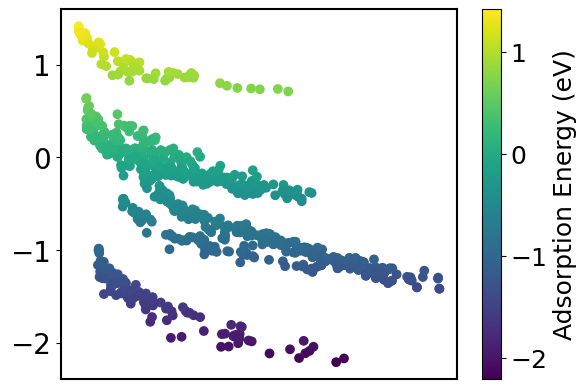

In [340]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)
plot_feature(X_embedded, targets)

In [341]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心
    center = np.trapz(energy * total_density, energy) / area

    return center

In [342]:
def calculate_d_band_center(energy, densities):
    # 求和所有态密度
    total_density = np.sum(densities, axis=1)
    # 计算能带的面积
    area = np.trapz(total_density, energy)

    # 计算带心
    center = np.trapz(energy * total_density, energy) / area

    return center

In [343]:
jjj = 300
datatest = data[jjj].x[0].reshape((-1, 5))
print(data[jjj].y)
datatest.shape

-0.7379878000000293


(800, 5)

In [344]:
calculate_d_band_center(-7 + 0.01 * np.array(range(datatest.shape[0])), datatest)

-2.450501207602817

In [345]:
data[jjj].x[0].shape

(4000,)

In [346]:
datatest

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

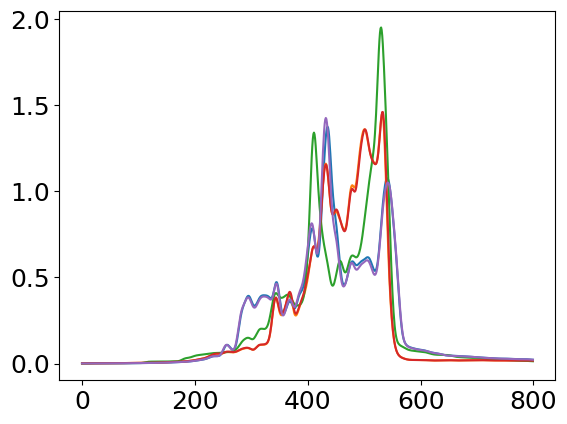

In [347]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

In [348]:
datatest

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

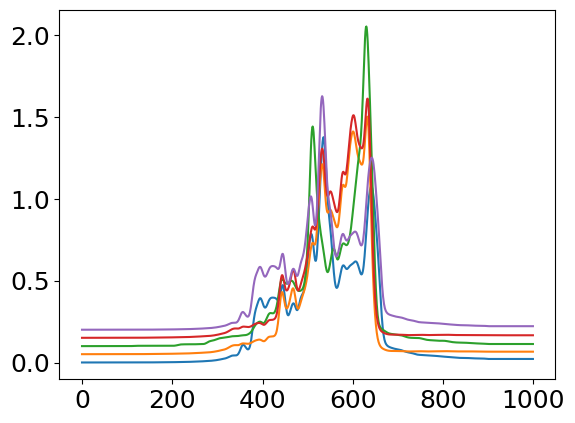

In [349]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

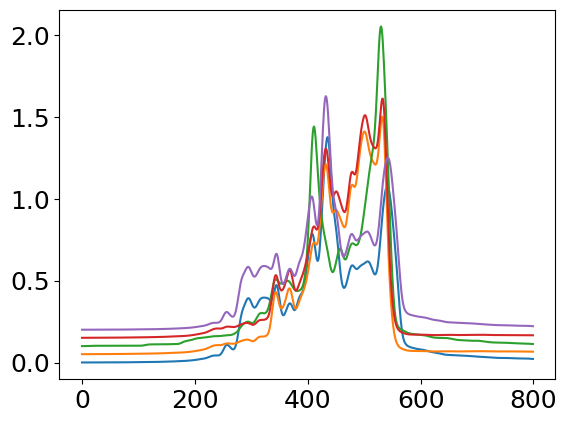

In [350]:
cover_i = cover[100:900, :]
for i in range(cover_i.shape[1]):
    plt.plot(range(cover_i.shape[0]), cover_i[:, i] + 0.05 * i)
plt.show()

In [351]:
datatest.shape[0]

800

In [352]:
import copy

data_height = []

for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[60 + 4 * i : 60 + 4 * i + datatest.shape[0], :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0

    data0.y = -(i - 10) * 0.1
    data_height.append(data0)
data_height[10].x[0].reshape(-1, 5)

array([[0.00036522, 0.00097945, 0.00021249, 0.00098348, 0.00037215],
       [0.00037099, 0.00099006, 0.00021943, 0.00099408, 0.00037796],
       [0.00037687, 0.00100091, 0.00023056, 0.00100483, 0.00038385],
       ...,
       [0.02232202, 0.0164198 , 0.0135064 , 0.01661624, 0.02247795],
       [0.02206211, 0.01635605, 0.01331674, 0.01654562, 0.02220212],
       [0.02181979, 0.01629501, 0.01313678, 0.01647588, 0.021933  ]])

In [353]:
data_height = np.array(data_height)

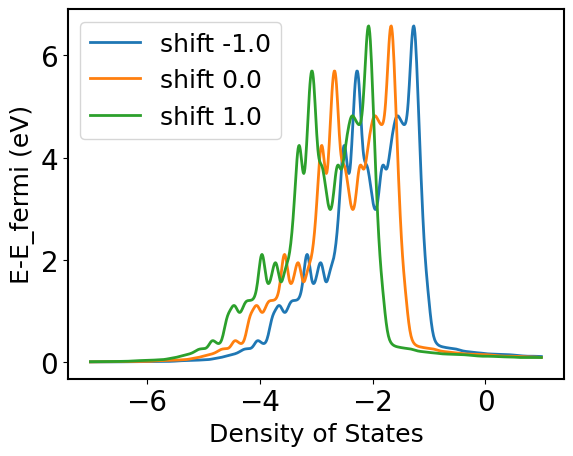

In [354]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_height[j].x[0].reshape(-1, 5)
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"shift {(j-10)*0.1}",
        linewidth=2.0,
    )
ax.set_ylabel("E-E_fermi (eV)")
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [355]:
loader_h = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)

In [356]:
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_h:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


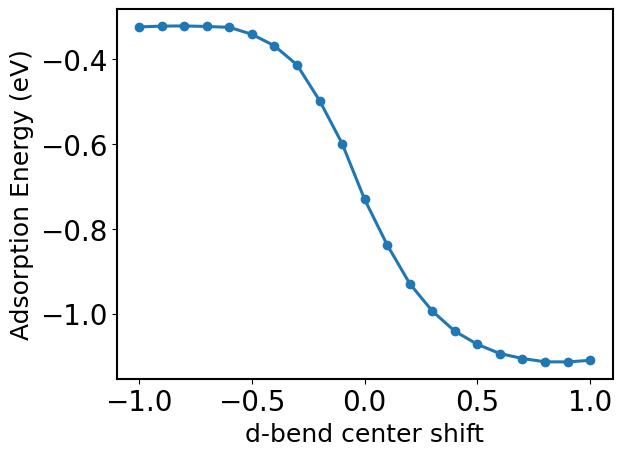

In [357]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend center shift")
plt.ylabel("Adsorption Energy (eV)")
plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [358]:
datatest.shape

(800, 5)

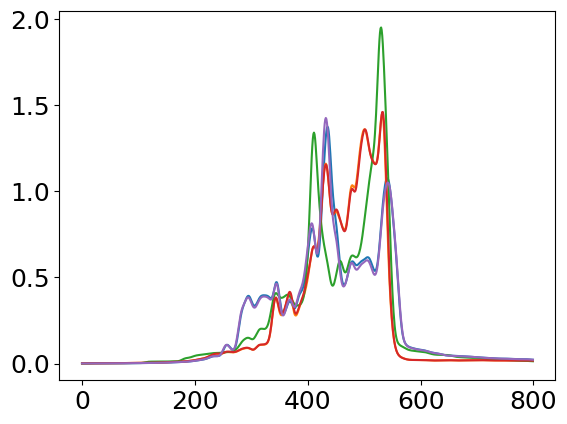

In [359]:
for i in range(datatest.shape[1]):
    plt.plot(range(datatest.shape[0]), datatest[:, i])
plt.show()

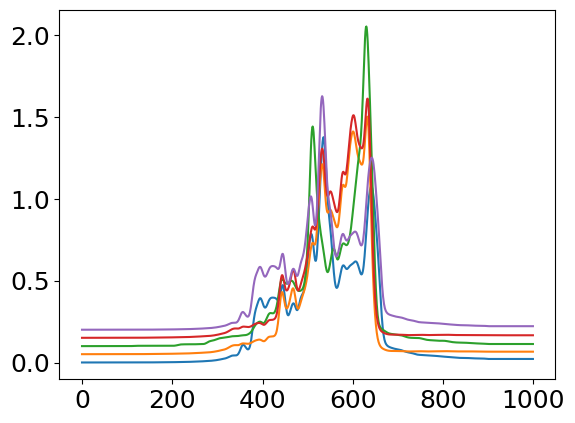

In [360]:
cover = np.zeros((datatest.shape[0] + 200, datatest.shape[1]))
cover[100:-100, :] = datatest
cover[:100, :] = datatest[0, :]
cover[-100:, :] = datatest[-1, :]

for i in range(cover.shape[1]):
    plt.plot(range(cover.shape[0]), cover[:, i] + 0.05 * i)
plt.show()

In [361]:
def interpolate(data, length):
    old_length = data.shape[0]
    x_old = np.linspace(0, 1, old_length)
    x_new = np.linspace(0, 1, length)
    y_new = np.interp(x_new, x_old, data)
    y_new = y_new * old_length / length
    return y_new

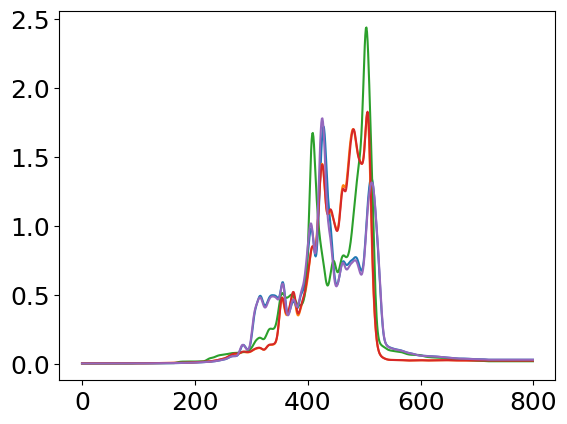

In [362]:
for i in range(cover.shape[1]):
    plt.plot(range(800), interpolate(cover[:, i], 800))
plt.show()

In [363]:
data_i = np.array([interpolate(cover[:, col], 800) for col in range(cover.shape[1])]).T

In [364]:
a = np.array([1, 2, 3, 4])
np.tile(a, 1)[1:-1]

array([2, 3])

In [365]:
data_width = []
for i in range(21):
    data0 = copy.deepcopy(data[jjj])
    data_i = cover[10 * i : cover.shape[0] - 10 * i, :]

    data_i = np.array(
        [interpolate(data_i[:, col], 800) for col in range(data_i.shape[1])]
    ).T

    pce = calculate_d_band_center(np.array(range(data_i.shape[0])), data_i)
    move = round(pce - 456)
    left = -min(move, 0)
    right = max(move, 0)
    up = np.tile(data_i[1, :], (left, 1))
    down = np.tile(data_i[-1, :], (right, 1))
    print(up.shape, data_i.shape, down.shape)
    data_i = np.concatenate((up, data_i, down), axis=0)
    data_i = data_i[right : data_i.shape[0] - left, :]
    data_i0 = data_i.reshape((1, -1))
    data0.x[:6] = data_i0
    data0.y = 800/cover[10 * i : cover.shape[0] - 10 * i, :].shape[0]
    print(cover[10 * i : cover.shape[0] - 10 * i, :].shape[0])
    data_width.append(data0)
data_width = np.array(data_width)

(9, 5) (800, 5) (0, 5)
1000
(9, 5) (800, 5) (0, 5)
980
(8, 5) (800, 5) (0, 5)
960
(7, 5) (800, 5) (0, 5)
940
(6, 5) (800, 5) (0, 5)
920
(6, 5) (800, 5) (0, 5)
900
(5, 5) (800, 5) (0, 5)
880
(4, 5) (800, 5) (0, 5)
860
(3, 5) (800, 5) (0, 5)
840
(2, 5) (800, 5) (0, 5)
820
(1, 5) (800, 5) (0, 5)
800
(0, 5) (800, 5) (0, 5)
780
(0, 5) (800, 5) (1, 5)
760
(0, 5) (800, 5) (2, 5)
740
(0, 5) (800, 5) (4, 5)
720
(0, 5) (800, 5) (5, 5)
700
(0, 5) (800, 5) (6, 5)
680
(0, 5) (800, 5) (8, 5)
660
(0, 5) (800, 5) (10, 5)
640
(0, 5) (800, 5) (11, 5)
620
(0, 5) (800, 5) (13, 5)
600


-0.6575825466290439
-0.08483484807385366
0.7161492348759566


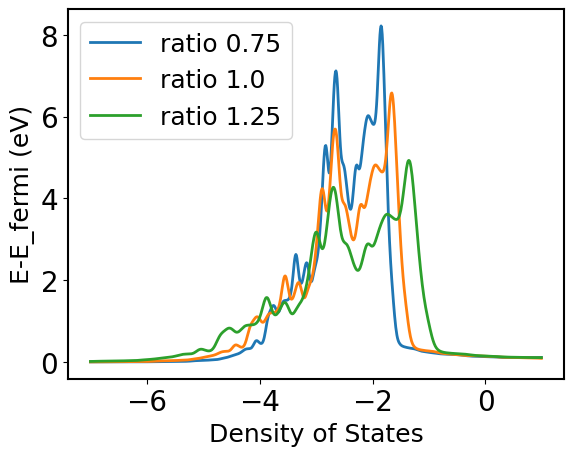

In [366]:
fig, ax = plt.subplots()
for j in [0, 10, 20]:
    p = data_width[j].x[0].reshape(-1, 5)
    pce = calculate_d_band_center(np.array(range(p.shape[0])), p)
    print((pce - 456))
    ax.plot(
        -7 + 0.010 * np.array(range(p.shape[0])),
        np.sum(p, axis=1),
        label=f"ratio {((600+20*j)/800)}",
        linewidth=2.0,
    )
ax.set_ylabel("E-E_fermi (eV)")
ax.set_xlabel("Density of States")
ax.legend()

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

plt.show()

In [367]:
loader_w = DisjointLoader(MyGraphDataset(data_width), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_w:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

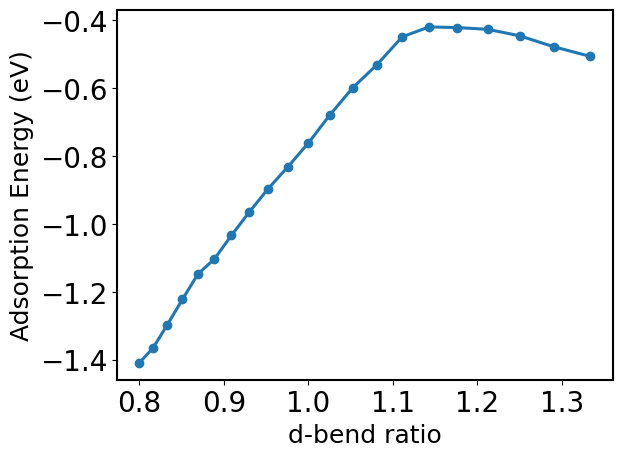

In [368]:
plt.plot(targets, predictions, marker="o", linestyle="-", linewidth =2.2)

plt.xlabel("d-bend ratio")
plt.ylabel("Adsorption Energy (eV)")

plt.xticks(fontsize=20)  # x轴刻度字体大小
plt.yticks(fontsize=20)  # y轴刻度字体大小

# 设置图框线粗细
bwith = 1.5  # 边框宽度设置为2
TK = plt.gca()  # 获取边框
TK.spines["bottom"].set_linewidth(bwith)
TK.spines["left"].set_linewidth(bwith)
TK.spines["top"].set_linewidth(bwith)
TK.spines["right"].set_linewidth(bwith)

In [369]:
loader_data = DisjointLoader(MyGraphDataset(data_height), batch_size=1, epochs=1)
predictions, targets, feature1, feature2, feature3 = [], [], [], [], []
for batch in loader_data:
    output, f1, f2, f3 = Model_feature(batch[0], training=False)
    predictions.append(output)
    feature1.append(f1)
    feature2.append(f2)
    feature3.append(f3)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

In [370]:
fone = [f.numpy().reshape((1, -1))[0] for f in feature1]
fone = np.array(fone)
fone.shape

(21, 1024)

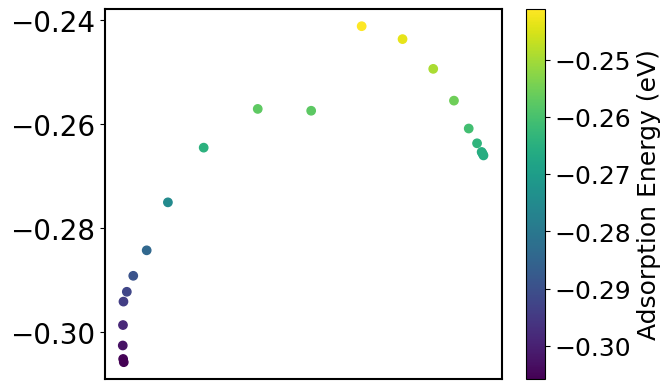

In [371]:
pca3 = PCA(n_components=1)
X_embedded = pca3.fit_transform(fone)
plot_feature(X_embedded, predictions)